In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])
import scipy as sp
import sympy as smp
from scipy.stats import rv_discrete
from scipy.stats import poisson

# Problem 1: Binomial 

Phenotype is measured and genotype is a latent random variable. Want to determine $p_A$, $p_B$, and $p_O$ so one can get the genotype frequencies (assumes Hard-Wienberg model).

![image](blood.PNG)

$$N_{A} = N_{AA} + N_{AO}$$
$$N_{B} = N_{BB} + N_{BO}$$
$$N_{O} = N_{O}$$
$$N_{AB} = N_{AB}$$

and $$p(n_a, n_b, n_o, n_{ab}| p_A, p_B, p_O) \propto (p_A^2 + 2p_Ap_O)^{n_A}\cdot (p_B^2 + 2p_Bp_O)^{n_B} \cdot (p_O^2)^{n_O} \cdot (2p_Ap_B)^{n_{AB}} $$

Want to estimate $p_A$, $p_B$, and $p_O$.

## Observed Data Liklihood
$$L(p_A, p_B, p_O | n_a, n_b, n_o, n_{ab}) \propto (p_A^2 + 2p_Ap_O)^{n_A}\cdot (p_B^2 + 2p_Bp_O)^{n_B} \cdot (p_O^2)^{n_O} \cdot (2p_Ap_B)^{n_{AB}} $$
## Complete Data Liklihood
$$L_C(p_A, p_B, p_O | n_{AA}, n_{AO}, n_{BB}, n_{BO}, n_{OO}, n_{AB}) \propto (p_A^2)^{n_{AA}} \cdot (2p_Ap_O)^{n_{AO}} \cdot (p_B^2)^{n_{BB}} \cdot (2p_Bp_O)^{n_{BO}} \cdot (p_O^2)^{n_{OO}} \cdot (2p_Ap_B)^{n_{AB}}$$ 

## E-Step
Let $n_X$ be one of the latent random variables representing genotype. Compute $$n_{X}^{(k+1)} = E[n_{X}|n_{A}, n_{B}, n_{O}, n_{AB}, p^{(k)}s]$$ For example, $n_{AA} = n_A\frac{p_A^2}{p_A^2+2p_Ap_O}$. This would normally be computed using observed data likelihood but in this case its straightforward.

## M-Step
Maximize complete data log likelihood with $n_{X}$ replaced with $n_{X}^{(k+1)}$ to get new estimates for $p^{k}$s. This requires computing derivatives of complete data liklihood:

In [2]:
import sympy as smp
pa, pb, po, naa, nao, nbb, nbo, noo, nab = smp.symbols('p_{A}, p_B, p_O, n_{AA}, n_{AO}, n_{BB}, n_{BO}, n_{OO}, n_{AB}', positive=True, real=True)

Define log liklihood

In [3]:
Lc = (pa**2)**(naa) *(2*pa*po)**(nao) * (pb**2)**nbb * (2*pb*po)**(nbo) * (po**2)**(noo)*(2*pa*pb)**(nab)
log_LC = smp.expand_log(smp.log(Lc))
log_LC

2*n_{AA}*log(p_{A}) + n_{AB}*(log(p_B) + log(p_{A}) + log(2)) + n_{AO}*(log(p_O) + log(p_{A}) + log(2)) + 2*n_{BB}*log(p_B) + n_{BO}*(log(p_B) + log(p_O) + log(2)) + 2*n_{OO}*log(p_O)

Solve for $\hat{p}_A$ and $\hat{p}_B$ in two equations, producing a system of linear equations

In [4]:
pa_hat = smp.solve(smp.diff(log_LC.subs(po, 1-pa-pb), pa), pa)[0]
pb_hat =smp.solve(smp.diff(log_LC.subs(po, 1-pa-pb), pb), pb)[0]
smp.linsolve([pa-pa_hat, pb-pb_hat], (pa, pb))

FiniteSet(((n_{AA} + n_{AB}/2 + n_{AO}/2)/(n_{AA} + n_{AB} + n_{AO} + n_{BB} + n_{BO} + n_{OO}), (n_{AB}/2 + n_{BB} + n_{BO}/2)/(n_{AA} + n_{AB} + n_{AO} + n_{BB} + n_{BO} + n_{OO})))

This means

$$\hat{p}_A^{(k+1)} = \frac{2n_{AA}^{(k+1)}+n_{AB}^{(k+1)}+n_{AO}^{(k+1)}}{2n} \hspace{10mm} \hat{p}_B^{(k+1)} = \frac{2n_{BB}^{(k+1)}+n_{AB}^{(k+1)}+n_{AO}^{(k+1)}}{2n}$$

## Implementing the Algorithm

True values and data

In [5]:
pt_A = 0.15
pt_B = 0.8
pt_O = 1 - pt_A - pt_B

In [6]:
ps = np.array([pt_A**2, 2*pt_A*pt_O, pt_B**2, 2*pt_B*pt_O, pt_O**2, 2*pt_A*pt_B])
types = np.arange(0, 6, 1)
type_dict = {'AA': 0, 'AO':1, 'BB':2, 'BO':3, 'OO':4, 'AB':5}

In [7]:
blood_rv = rv_discrete(values=(types, ps))
data = blood_rv.rvs(size=1000)
nA = sum((data==type_dict['AA']) + (data==type_dict['AO']))
nB = sum((data==type_dict['BB']) + (data==type_dict['BO']))
nO = sum(data==type_dict['OO'])
nAB = sum(data==type_dict['AB'])

In [8]:
[nA, nB, nO, nAB]

[44, 706, 2, 248]

Get maximum likelihood estimator of $p_A$, $p_B$, and $p_O$.

In [9]:
def E_step(na, nb, no, nab, pa, pb, po):
    return [na*pa**2 / (pa**2 + 2*pa*po) , #naa
            nb*pb**2 / (pb**2 + 2*pb*po) , #nbb
            na*2*pa*po / (pa**2 + 2*pa*po) , #nao
            nb*2*pb*po / (pb**2 + 2*pb*po) , #nbo
            no, #noo
            nab] #nab
def M_step(naa, nbb, nab, nao, nbo, noo):
    n = naa+nbb+nab+nao+nbo+noo
    pa = (2*naa+nab+nao)/(2*n)
    pb = (2*nbb+nab+nbo)/(2*n)
    po = 1-pa-pb
    return pa, pb, po

Run algorithm

In [10]:
pa0 = pb0 = po0 = 1/3.
pas = [pa0]; pbs = [pb0]; pos = [po0]

In [11]:
for i in range(20):
    pa, pb, po = pas[-1], pbs[-1], pos[-1]
    # E Step
    naa, nbb, nao, nbo, noo, nab = E_step(nA, nB, nO, nAB, pa, pb, po)
    # M Step
    pa_new, pb_new, po_new = M_step(naa, nbb, nab, nao, nbo, noo)
    pas.append(pa_new); pbs.append(pb_new); pos.append(po_new)    

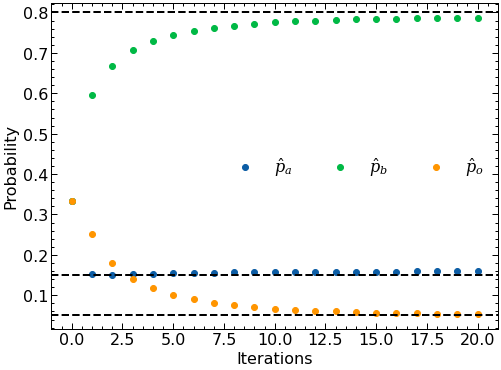

In [12]:
ns = np.arange(0, len(pas), 1)
plt.scatter(ns, pas, label='$\hat{p}_a$')
plt.scatter(ns, pbs, label='$\hat{p}_b$')
plt.scatter(ns, pos, label='$\hat{p}_o$')
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.legend(ncol=3)
plt.axhline(pt_A, color='k', ls='--')
plt.axhline(pt_B, color='k', ls='--')
plt.axhline(pt_O, color='k', ls='--')

#plt.ylim(top=0.6)

# Poisson Mixture

In [13]:
a = poisson.rvs(mu= 5, size=10000)
b = poisson.rvs(mu= 10, size=10000)

[]

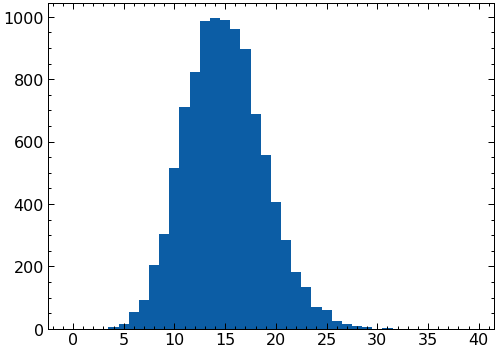

In [17]:
bins = np.arange(-0.5, 40.5, 1)
plt.hist(a+b, bins=bins)
plt.plot()